In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import urllib.request
from konlpy.tag import Okt
from tqdm import tqdm
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

In [11]:
cL_df = pd.read_csv('D:/pythonTest/DataShipJo/chicken_label.csv', names=['아이디', '리뷰', 'Label'])
cL_df.head()

,아이디,리뷰,Label
0,oo**님,N,1
1,de**님,잘 먹었습니다,0
2,pr**님,양이 많이 줄어든 느낌 이네요.,1
3,sk**님,오늘도 맛나게 잘 먹었습니다~~~,1
4,gh**님,맛있어요 양도 많아요,1


In [16]:
train_data, test_data = train_test_split(cL_df, test_size = 0.2, random_state=156)

In [20]:
# 훈련용 리뷰 개수 출력
print('훈련용 리뷰 개수 :',len(train_data)) 

훈련용 리뷰 개수 : 16084


In [21]:
# 테스트용 리뷰 개수 출력
print('테스트용 리뷰 개수:',len(test_data)) 

테스트용 리뷰 개수: 4022


In [23]:
train_data.head()

,아이디,리뷰,Label
19400,a0**님,진짜 맛있어요 ㅎㅎ 요청사항도 들어주셔서 너무 감사했어여 ㅜㅜ,1
893,xu**님,맛있게 잘 먹었어요.,1
3932,fe**님,평소랑 다르게 좀 오버쿠킹되서 전자렌지에 한번데운 닭상태로 왔네요.. 앞전엔 잘왔는...,0
16463,ha**님,항상 맛있게 잘 먹고 있습니다. 오늘도 잘 먹었습니다. 양념맛이 특히 칼칼하고 맛있어요.,1
13156,sy**님,맛아주굿입니다~~~,1


In [24]:
test_data.head()

,아이디,리뷰,Label
12293,ti**님,소스 좀 많은데?? 적당히 넣었으면 좋겠어요~ 맛이 좋아요!,1
7359,lk**님,맛있어용 중국향음식좋아하시는 분들은 좋아하시겠네요 ㅎ,1
10793,98**님,색다른 맛이지만 제 입맛에는 별로..또시키지는 않을듯.,1
15175,mr**님,"닭의 상태가 너~무 깨끗하고 땡땡해서 놀랐어요.\n후추때문인지 생각보다 맵긴했지만,...",1
14552,wo**님,완전 맛있어요 다음에 또먹을게요 ㅎㅎㅎ,1


## 데이터 중복 유무 확인

In [27]:
# '리뷰'열과 'Label'열의 중복을 제외한 값의 개수
print('훈련용 리뷰 개수 :',len(train_data)) 
train_data['리뷰'].nunique(), train_data['Label'].nunique()

### 1500개 정도의 중복 데이터 확인 ###

훈련용 리뷰 개수 : 16084


(14409, 2)

In [28]:
# '리뷰'열의 중복 제거
train_data.drop_duplicates(subset=['리뷰'], inplace=True)

C:\Users\USER\anaconda3\lib\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [29]:
print('훈련용 리뷰 개수 :',len(train_data)) 

훈련용 리뷰 개수 : 14409


<AxesSubplot:>

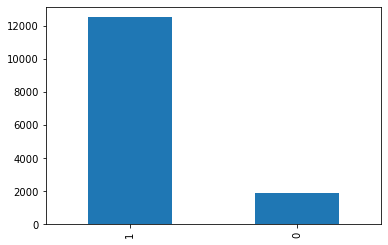

In [30]:
# train_data에서 해당 리뷰의 긍, 부정 유무가 기재되어있는 레이블(Label) 값의 분포
train_data['Label'].value_counts().plot(kind = 'bar')

In [33]:
# 'Label'의 값이 정확히 몇개인지 확인
print(train_data.groupby('Label').size().reset_index(name = 'count'))

### 부정:: 1881, 긍정:: 12528 ###

   Label  count
0      0   1881
1      1  12528


In [37]:
# train_data 결측값 확인
train_data.isna().sum()

아이디      0
리뷰       0
Label    0
dtype: int64

### 결측값 위치 확인
train_data.loc[train_data.document.isnull()]

### 결측값 제거
#### Null 값이 존재하는 행 제거
train_data = train_data.dropna(how = 'any') 
#### Null 값이 존재하는지 확인
print(train_data.isnull().values.any()) 

## 데이터 전처리

In [40]:
# 한글과 공백을 제외하고 모두 제거
train_data['리뷰'] = train_data['리뷰'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
train_data[:5]

,아이디,리뷰,Label
19400,a0**님,진짜 맛있어요 ㅎㅎ 요청사항도 들어주셔서 너무 감사했어여 ㅜㅜ,1
893,xu**님,맛있게 잘 먹었어요,1
3932,fe**님,평소랑 다르게 좀 오버쿠킹되서 전자렌지에 한번데운 닭상태로 왔네요 앞전엔 잘왔는데 아쉽,0
16463,ha**님,항상 맛있게 잘 먹고 있습니다 오늘도 잘 먹었습니다 양념맛이 특히 칼칼하고 맛있어요,1
13156,sy**님,맛아주굿입니다,1


In [42]:
# 정규표현식 후 결측값 확인
train_data['리뷰'] = train_data['리뷰'].str.replace('^ +', "") 
train_data['리뷰'].replace('', np.nan, inplace=True)
print(train_data.isnull().sum())

아이디        0
리뷰       118
Label      0
dtype: int64


In [44]:
# 결측값 확인
train_data.loc[train_data.리뷰.isnull()][:5]

,아이디,리뷰,Label
11424,손님,NaN,1
10795,da**님,NaN,0
866,co**님,NaN,1
0,oo**님,NaN,1
13269,mo**님,NaN,1


In [45]:
# 결측값 삭제
train_data = train_data.dropna(how = 'any')
print(len(train_data))

14291


In [48]:
# test_data 또한 동일하게 전처리 진행

test_data.drop_duplicates(subset = ['리뷰'], inplace=True) # '리뷰'열에서 중복인 내용이 있다면 중복 제거
test_data['리뷰'] = test_data['리뷰'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
test_data['리뷰'] = test_data['리뷰'].str.replace('^ +', "") # 공백은 empty 값으로 변경
test_data['리뷰'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
test_data = test_data.dropna(how='any') # Null 값 제거
print('전처리 후 테스트용 샘플의 개수 :',len(test_data))

전처리 후 테스트용 샘플의 개수 : 3757


In [49]:
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

In [53]:
okt = Okt()
okt.morphs('와 이런 것도 치킨이라고 차라리 닭가슴살을 만드는 게 나을 뻔', stem = True)

['오다',
 '이렇다',
 '것',
 '도',
 '치킨',
 '이라고',
 '차라리',
 '닭',
 '가슴',
 '살',
 '을',
 '만들다',
 '게',
 '나다',
 '뻔']

In [54]:
### 토큰화 후 X_train 에 저장 ###
X_train = []
for sentence in tqdm(train_data['리뷰']):
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    X_train.append(stopwords_removed_sentence)

100%|███████████████████████████████████████████████████████████████████████████| 14291/14291 [01:15<00:00, 188.74it/s]


In [55]:
print(X_train[:3])

[['진짜', '맛있다', 'ㅎㅎ', '요청', '사항', '들어주다', '너무', '감사하다', 'ㅜㅜ'], ['맛있다', '자다', '먹다'], ['평소', '랑', '다르다', '오버쿠킹되', '서', '전자렌지', '한번', '데우다', '닭', '상태', '로', '오다', '앞전', '엔', '오다', '아쉽다']]


In [56]:
### 토큰화 후 X_test 에 저장 ###
X_test = []
for sentence in tqdm(test_data['리뷰']):
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    X_test.append(stopwords_removed_sentence)

100%|█████████████████████████████████████████████████████████████████████████████| 3757/3757 [00:28<00:00, 130.22it/s]


### 정수 인코딩
기계가 텍스트를 숫자로 처리할 수 있도록 훈련 데이터와 테스트 데이터에 정수 인코딩을 수행한다

In [57]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [58]:
print(tokenizer.word_index)

{'맛있다': 1, '먹다': 2, '배달': 3, '맛': 4, '시키다': 5, '너무': 6, '좋다': 7, '치킨': 8, '자다': 9, '보다': 10, '오다': 11, '빠르다': 12, '많다': 13, '있다': 14, '요': 15, '감사하다': 16, '이다': 17, '항상': 18, '양도': 19, 'ㅎㅎ': 20, '링클': 21, '주문': 22, '같다': 23, '진짜': 24, '뿌': 25, '다': 26, '역시': 27, '만': 28, '정말': 29, '또': 30, '을': 31, '로': 32, '최고': 33, '양': 34, '바삭': 35, '후라이드': 36, '양념': 37, '점': 38, '많이': 39, '안': 40, '넘다': 41, '하고': 42, '시간': 43, '처음': 44, '빨리': 45, '더': 46, '없다': 47, '않다': 48, '서비스': 49, '치즈볼': 50, '잇다': 51, '리뷰': 52, '다음': 53, '소스': 54, '오늘': 55, '튀김': 56, '나다': 57, '시립대': 58, '닭': 59, 'ㅠㅠ': 60, '여기': 61, '나': 62, '떡': 63, '서': 64, '받다': 65, '것': 66, '엄청': 67, '친절하다': 68, '고': 69, '주다': 70, '분': 71, '사진': 72, '찍다': 73, '살': 74, '아쉽다': 75, '가루': 76, '에서': 77, '순': 78, '좋아하다': 79, '못': 80, '때': 81, '맛초킹': 82, '이벤트': 83, '되다': 84, '다른': 85, '자주': 86, '빨르다': 87, '습': 88, '소': 89, '뿌링클': 90, '조금': 91, '네': 92, '짜다': 93, '늦다': 94, '해주다': 95, '생각': 96, '킹': 97, '아니다': 98, '님': 99, '그렇다': 100, '까지': 101, '인

In [59]:
threshold = 3
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 6593
등장 빈도가 2번 이하인 희귀 단어의 수: 3917
단어 집합에서 희귀 단어의 비율: 59.411497042317606
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.2463226836628367


In [60]:
# 전체 단어 개수 중 빈도수 2이하인 단어는 제거.
# 0번 패딩 토큰을 고려하여 + 1
vocab_size = total_cnt - rare_cnt + 1
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 2677


In [61]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
tokenizer = Tokenizer(vocab_size) 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [62]:
# 정수 인코딩이 되었는지 확인
print(X_train[:3])

[[24, 1, 20, 182, 229, 319, 6, 16, 148], [1, 9, 2], [324, 137, 291, 64, 1727, 247, 885, 59, 273, 32, 11, 120, 11, 75]]


In [64]:
# train_data에서 y_train과 y_test를 별도로 저장해준다
y_train = np.array(train_data['Label'])
y_test = np.array(test_data['Label'])

### 빈 샘플(empty samples) 제거
전체 데이터에서 빈도수가 낮은 단어가 삭제되었다는 것은 빈도수가 낮은 단어만으로 구성되었던 샘플들은 빈(empty) 샘플이 되었다는 것을 의미합니다. 빈 샘플들은 어떤 레이블이 붙어있던 의미가 없으므로 빈 샘플들을 제거해주는 작업을 하겠습니다. 각 샘플들의 길이를 확인해서 길이가 0인 샘플들의 인덱스를 받아오겠습니다.

In [65]:
drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]

In [66]:
# 빈 샘플들을 제거
X_train = np.delete(X_train, drop_train, axis=0)
y_train = np.delete(y_train, drop_train, axis=0)
print('X_train 샘플 제거 후 개수:',len(X_train))
print('y_train 샘플 제거 후 개수:',len(y_train))

X_train 샘플 제거 후 개수: 14261
y_train 샘플 제거 후 개수: 14261


### 패딩
서로 다른 길이의 샘플들의 길이를 동일하게 맞춰주는 패딩 작업 진행

리뷰의 최대 길이 : 89
리뷰의 평균 길이 : 10.027347310847766


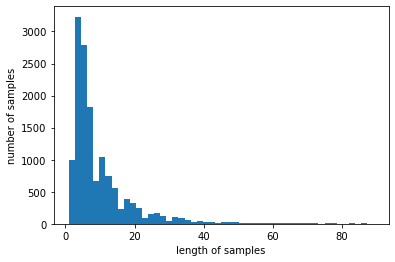

In [67]:
# 전체 데이터에서 가장 길이가 긴 리뷰와 전체 데이터의 길이 분포

print('리뷰의 최대 길이 :',max(len(review) for review in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(review) for review in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

가장 긴 리뷰의 길이는 89이며, 그래프를 봤을 때 전체 데이터의 길이 분포는 대체적으로 약 11내외의 길이를 가지는 것을 볼 수 있습니다. 모델이 처리할 수 있도록 X_train과 X_test의 모든 샘플의 길이를 특정 길이로 동일하게 맞춰줄 필요가 있습니다. 특정 길이 변수를 max_len으로 정합니다. 대부분의 리뷰가 내용이 잘리지 않도록 할 수 있는 최적의 max_len의 값은 몇일까요? 전체 샘플 중 길이가 max_len 이하인 샘플의 비율이 몇 %인지 확인하는 함수를 만듭니다.

In [68]:
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

In [69]:
max_len = 30
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 30 이하인 샘플의 비율: 95.3719935488395


In [70]:
# 전체 훈련 데이터 중 약 94%의 리뷰가 30이하의 길이를 가지는 것을 확인
# 모든 샘플의 길이를 30으로 맞추기
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

In [71]:
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

embedding_dim = 100
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(LSTM(hidden_units))
model.add(Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=64, validation_split=0.2)

Epoch 1/15
178/179 [============================>.] - ETA: 0s - loss: 0.3966 - acc: 0.8668
Epoch 1: val_acc improved from -inf to 0.86505, saving model to best_model.h5
179/179 [==============================] - 16s 68ms/step - loss: 0.3966 - acc: 0.8668 - val_loss: 0.3904 - val_acc: 0.8651
Epoch 2/15
178/179 [============================>.] - ETA: 0s - loss: 0.3761 - acc: 0.8696
Epoch 2: val_acc did not improve from 0.86505
179/179 [==============================] - 11s 62ms/step - loss: 0.3760 - acc: 0.8697 - val_loss: 0.3897 - val_acc: 0.8651
Epoch 3/15
178/179 [============================>.] - ETA: 0s - loss: 0.3621 - acc: 0.8708
Epoch 3: val_acc did not improve from 0.86505
179/179 [==============================] - 11s 60ms/step - loss: 0.3620 - acc: 0.8708 - val_loss: 0.4039 - val_acc: 0.8630
Epoch 4/15
178/179 [============================>.] - ETA: 0s - loss: 0.3516 - acc: 0.8739
Epoch 4: val_acc did not improve from 0.86505
179/179 [==============================] - 11s 61ms

In [72]:
loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

118/118 [==============================] - 2s 12ms/step - loss: 0.3880 - acc: 0.8680

 테스트 정확도: 0.8680


In [73]:
def sentiment_predict(new_sentence):
  new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', new_sentence)
  new_sentence = okt.morphs(new_sentence, stem=True) # 토큰화
  new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
  encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
  pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
  score = float(loaded_model.predict(pad_new)) # 예측
  if(score > 0.5):
    print("{:.2f}% 확률로 긍정 리뷰입니다.\n".format(score * 100))
  else:
    print("{:.2f}% 확률로 부정 리뷰입니다.\n".format((1 - score) * 100))

In [101]:
sentiment_predict('치킨 다 식어서 오고 퍽퍽해서 한입먹고 다버림, 역대 최악의 치킨이였음, 다시는 여기서 안시킴')

85.72% 확률로 긍정 리뷰입니다.

